# Important Stats

<div>
<img src="Stats.png" width="400"/>
    </div>

<div>
<img src="Statistics.png" width="400"/>
    </div>

In [1]:
R = 99377 # range

# Intro to project

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [3]:
df = pd.read_excel("data.xlsx")

In [6]:
df.dtypes

ID                int64
Carat Weight    float64
Cut              object
Color            object
Clarity          object
Polish           object
Symmetry         object
Report           object
Price             int64
dtype: object

In [7]:
df.columns

Index(['ID', 'Carat Weight', 'Cut', 'Color', 'Clarity', 'Polish', 'Symmetry',
       'Report', 'Price'],
      dtype='object')

In [8]:
df_new = pd.get_dummies(df, columns=['Cut', 'Color', 'Clarity', 'Polish', 'Symmetry', 'Report'])
df_new.drop("ID", axis=1, inplace=True)

In [9]:
df_new.head()

,Carat Weight,Price,Cut_Fair,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Color_D,Color_E,Color_F,...,Polish_EX,Polish_G,Polish_ID,Polish_VG,Symmetry_EX,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_AGSL,Report_GIA
0,1.10,5169,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
1,0.83,3470,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2,0.85,3183,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
3,0.91,4370,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,0.83,3171,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1


In [10]:
df_new.shape

(6000, 30)

In [11]:
X = df_new.drop("Price", axis=1)
y = df_new["Price"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=8)

## Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_model.score(X_test, y_test)

0.8643143717610149

__Из-за сравнительно меньшего результата, в дальнейшем мы не будем использовать линейную регрессию__

## Decision Tree Regression

In [15]:
from sklearn.tree import DecisionTreeRegressor

In [16]:
dec_model = DecisionTreeRegressor()
dec_model.fit(X_train, y_train)
dec_model.score(X_test, y_test)

0.9600042622755353

In [17]:
y_pred = dec_model.predict(X_test)
mse_dec = mean_squared_error(y_test, y_pred)
print(np.sqrt(mse_dec), np.sqrt(mse_dec)/R )

1953.4044821086256 0.019656504846278573


__Процент ошибки не составляет более двух процентов, что является более менее приемлемо__

## Random Forest Regression

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
random_model = RandomForestRegressor()
random_model.fit(X_train, y_train)
random_model.score(X_test, y_test)

0.9753176434394875

In [21]:
y_pred = random_model.predict(X_test)
mse_random = mean_squared_error(y_test, y_pred)
print(np.sqrt(mse_random), np.sqrt(mse_random)/R )

1534.5414892129759 0.015441616160811616


__Процент ошибки не составляет более полтора процентов, что лучше чем предыдущая модель__

## XGBoost Regression 

In [22]:
from xgboost import XGBRegressor

In [23]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.9834671891565371

In [24]:
y_pred = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred)
print(np.sqrt(mse_xgb), np.sqrt(mse_xgb)/R )

1255.9104452456604 0.012637838184345074


__Процент ошибки упал до 1.2 процентов, что являеться лучшим среди данных трех__

## XGBoost Graph

In [25]:
y_pred_xgb = xgb_model.predict(X)

In [26]:
y_pred_xgb

array([ 5306.856 ,  3544.0225,  3349.8835, ...,  6256.2793, 11302.474 ,
       31379.951 ], dtype=float32)

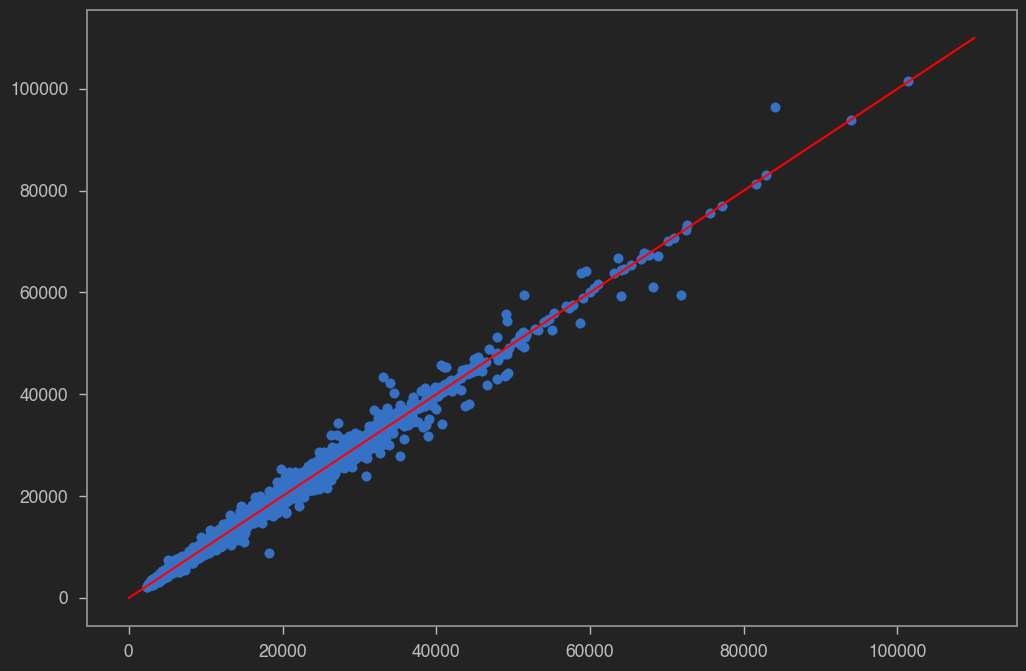

In [27]:
plt.figure(figsize=(12,8))
plt.scatter(y_pred_xgb, y)
plt.plot(range(110000), range(110000), c='red')

__Так как нам нужно получить лучшие бриллианты за свою цену, то мы должны найти такие, которые ниже графика регрессии__

In [28]:
y_diff_xgb = y - y_pred_xgb
y_diff_xgb

0      -137.855957
1       -74.022461
2      -166.883545
3      -157.957031
4      -137.196045
           ...    
5995   -189.373535
5996   -320.136230
5997    -99.279297
5998    -96.473633
5999   -872.951172
Name: Price, Length: 6000, dtype: float64

In [29]:
y_result_xgb = pd.DataFrame({"Price": y, 'Real Value': y_pred_xgb, 'Ratio': y_pred_xgb / y, "Diff": y_diff_xgb})
y_result_xgb[(y_result_xgb["Diff"] < -5000)]

,Price,Real Value,Ratio,Diff
1013,31724,38915.859375,1.226701,-7191.859375
1641,8803,18237.214844,2.071705,-9434.214844
2264,38072,44202.492188,1.161024,-6130.492188
2582,27942,35218.863281,1.260427,-7276.863281
2592,59415,71889.234375,1.209951,-12474.234375
3739,44115,49299.742188,1.117528,-5184.742188
4181,23864,30834.037109,1.292073,-6970.037109
4191,43770,49131.152344,1.122485,-5361.152344
4364,34225,40755.535156,1.190812,-6530.535156
5219,43556,48901.132812,1.122719,-5345.132812


## Random Forest Graph

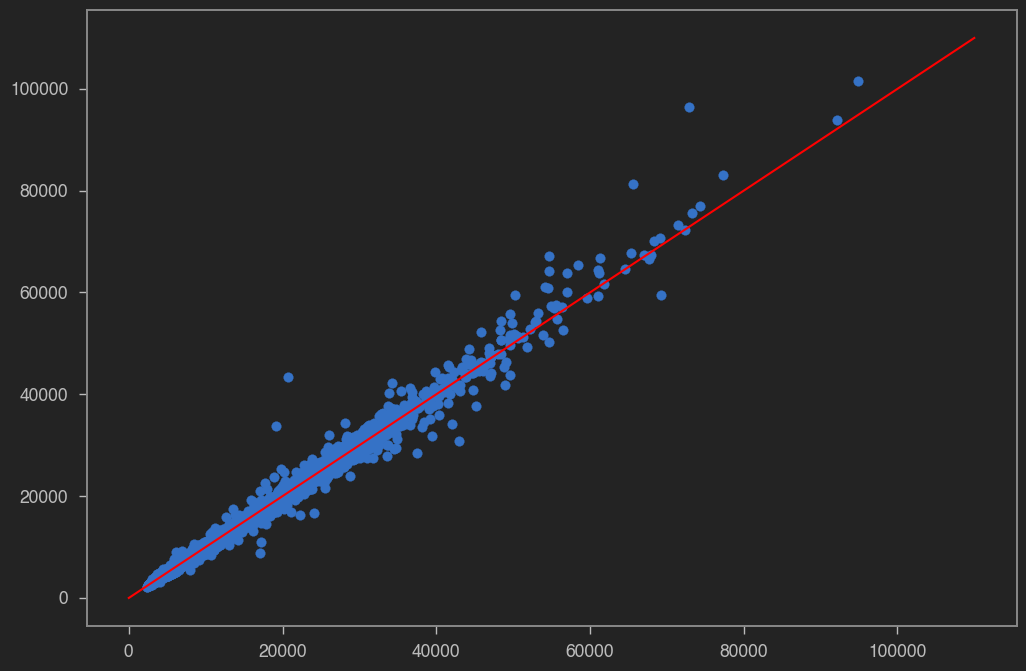

In [28]:
y_pred_random = random_model.predict(X)
plt.figure(figsize=(12,8))
plt.scatter(y_pred_random, y)
plt.plot(range(110000), range(110000), c='red')

In [29]:
y_diff_random = y - y_pred_random
y_result_random = pd.DataFrame({"Price": y, 'Real Value': y_pred_random, 'Ratio': y_pred_random / y, "Diff": y_diff_random})
y_result_random[(y_result_random["Diff"] < -5000)]

,Price,Real Value,Ratio,Diff
32,41867,48929.380000,1.168686,-7062.380000
124,16697,24046.940000,1.440195,-7349.940000
514,30867,42963.990000,1.391907,-12096.990000
1013,31724,39439.201238,1.243198,-7715.201238
1641,8803,17039.233667,1.935617,-8236.233667
2582,27942,33582.815000,1.201876,-5640.815000
2592,59415,69263.660000,1.165760,-9848.660000
2995,28557,37520.240000,1.313872,-8963.240000
4191,43770,49582.101333,1.132787,-5812.101333
4364,34225,41985.840000,1.226759,-7760.840000


## Decision Tree Graph

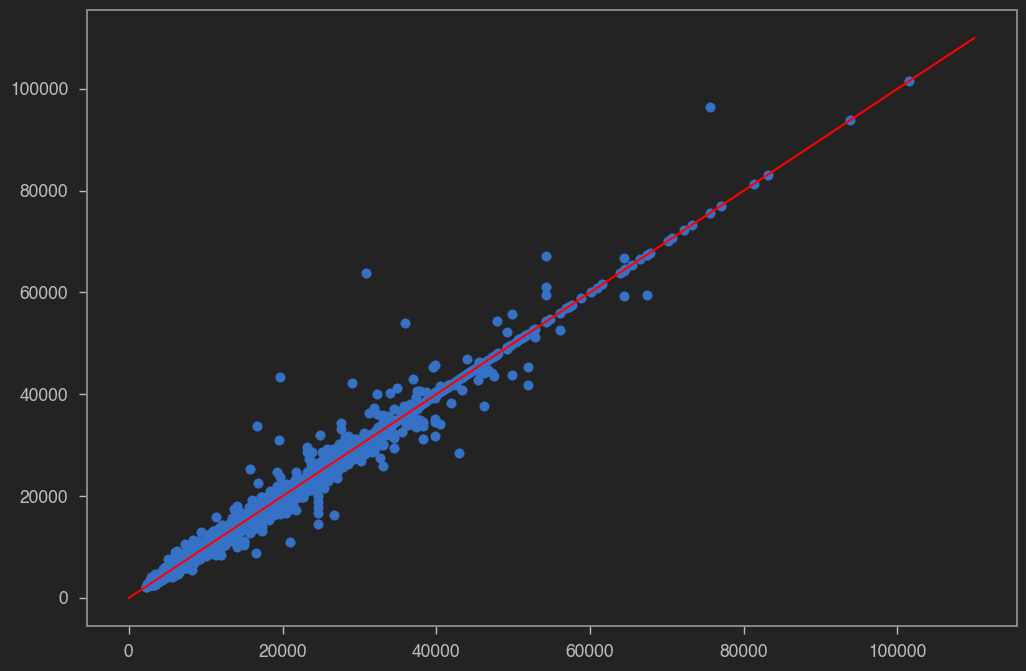

In [30]:
y_pred_dec = dec_model.predict(X)
plt.figure(figsize=(12,8))
plt.scatter(y_pred_dec, y)
plt.plot(range(110000), range(110000), c='red')

In [31]:
y_diff_dec = y - y_pred_dec
y_result_dec = pd.DataFrame({"Price": y, 'Real Value': y_pred_dec, 'Ratio': y_pred_dec / y, "Diff": y_diff_dec})
y_result_dec[(y_result_dec["Diff"] < -5000)]

,Price,Real Value,Ratio,Diff
32,41867,51928.0,1.240309,-10061.0
41,34657,39834.0,1.149378,-5177.0
124,16697,24578.0,1.472001,-7881.0
785,59282,64453.0,1.087227,-5171.0
1013,31724,39834.0,1.255642,-8110.0
1437,45392,51928.0,1.143990,-6536.0
1641,8803,16605.0,1.886289,-7802.0
1908,25848,33020.0,1.277468,-7172.0
2592,59415,67368.0,1.133855,-7953.0
2995,28557,43002.0,1.505830,-14445.0


# Описание результатов
---
Мы получили разные данные по бриллиантам с разных регрессионных моделей, теперь наша задача состоит в том чтобы правильно использовать данную информацию, и выделить 5 лучших вариантов бриллиантов для Сары:
1. Самая часто встречающаяся модель бриллианта имеет индекс 1641 (ID = 1642), и она всегда имееет лучшие показатели соотношения реальной себестоимости на цену предлагаемую в магазине (Ratio > 1.88). 
2. Дальше, хотелось бы выделить модель с индексом 2592 (ID = 2593), так как она также встречается во всех трех регрессионных моделях, а также имеет хорошие значение в разности (Diff > 7953).
3. Потому как мы выделили уже 2 модели, которые сильно разнятся по цене, то следующую стоит выбрать так, чтобы ее цена было около среднего значение двух предыдущих. Под такие критерии отлично подходит модель с индексом 4364 (ID = 4365), так как она встречается во всех регрессионных моделях, а также имеет неплохие значения в разнице и соотношении.
4. Следующим вариантом мог бы быть бриллиант с индексом 4191 (ID = 4192), она как и все остальные присутствует в регрессионных моделях, а также имеет хорошие показатели, но данная модель являеться, что-то средним между моделями с индексами 2592 и 4364.
5. И последним будет модель с индексом 4181 (ID = 4182), хоть она и не появилось в регрессионной модели дерева решений, что может быть обусловленно худшей результативностью среди трех моделей, данный вариант являеться следующим по бюджету после 1641, имея отличные показатели в регрессионных моделях XGBoost и Random Forest.

# Result

In [32]:
df[df["ID"].isin([1642, 2593, 4365, 4192, 4182])]

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
1641,1642,2.00,Very Good,H,SI1,EX,EX,GIA,8803
2592,2593,2.35,Very Good,D,IF,VG,VG,GIA,59415
4181,4182,2.27,Ideal,H,VVS2,EX,EX,GIA,23864
4191,4192,2.11,Ideal,D,VVS2,EX,EX,GIA,43770
4364,4365,2.23,Ideal,F,VVS2,EX,EX,GIA,34225
